<a href="https://colab.research.google.com/github/sournara/Computer_Vision_Study/blob/main/PyTorch/PyTorch_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 학습 코드를 실행하기 전에 [런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 [GPU]로 설정한다.
### **데이터 세트 다운로드**
- 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb796/korean_face_age_dataset custom_korean_family_dataset_resolution_128

Cloning into 'custom_korean_family_dataset_resolution_128'...
remote: Enumerating objects: 27577, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 27577 (delta 0), reused 6 (delta 0), pack-reused 27571
Receiving objects: 100% (27577/27577), 76.04 MiB | 19.61 MiB/s, done.
Updating files: 100% (53072/53072), done.


### **라이브러리 불러오기(Load Libraries)**
- 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import pandas as pd
from PIL import Image
import os

### **데이터 세트 불러오기(Load Dataset)**
1. **데이터 증진(data augmentation)**을 명시하여 초기화할 수 있다.
    - 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 **DataLoader()**를 이용하여 실질적으로 데이터를 불러올 수 있다.
    - 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
    - **next() 함수**를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.

- **Reference** : https://github.com/ndb796/korean_face_age_classification (AI Hub)

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

- 데이터 세트를 확인한다.
    - **Training dataset** : (F0001 ~ F0299) folders have 10,025 images.
    - **Validation dataset** : (F0801 ~ F0850) folders have 1,539 images.
    - **Test dataset** : (F0851 ~ F0900) folders have 1,504 images.

In [4]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data) :
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows() :
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [5]:
class Dataset(Dataset) :
    def __init__(self, meta_data, image_directory, transform = None) :
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a" : 0, "b" : 1, "c" : 2, "d" : 3, "e" : 4, "f" : 5, "g" : 6, "h" : 7
        }

    def __len__(self) :
        return len(self.meta_data)

    def __getitem__(self, idx) :
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform :
            img = self.transform(img)

        return img, label

In [10]:
label_to_age = {
    0 : "0-6 years old",
    1 : "7-12 years old",
    2 : "13-19 years old",
    3 : "20-30 years old",
    4 : "31-45 years old",
    5 : "46-55 years old",
    6 : "56-66 years old",
    7 : "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

val_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)

val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle = False)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

### **데이터 시각화(Data Visualization)**

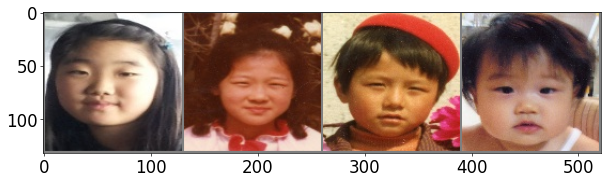

['13-19 years old', '13-19 years old', '7-12 years old', '0-6 years old']


In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size' : 20})

def imshow(input) :
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([label_to_age[labels[i].item()] for i in range(4)])

### **딥러닝 모델 학습(Training)**
- 사전 학습된(pre-trained) 모델을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
    - 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치시킨다.

In [13]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8) # transfer learning
model =  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [16]:
import time

def train() :
    start_time = time.time()
    print(f'[Epoch : {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader) :
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1 :
            print(f'[Batch : {i + 1}] running train loss : {running_loss / total}, running train accuracy : {running_corrects / total}')

    print(f'train loss : {running_loss / total}, accuracy : {running_corrects / total}')
    print("elapsed time : ", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def validate() :
    start_time = time.time()
    print(f'[Epoch : {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader) :
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad() :
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1) :
            print(f'[Batch : {i + 1}] running val loss : {running_loss / total}, running val accuracy : {running_corrects / total}')

    print(f'val loss : {running_loss / total}, accuracy : {running_corrects / total}')
    print("elapsed time : ", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test() :
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader) :
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad() :
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1) :
            print(f'[Batch : {i + 1}] running test loss : {running_loss / total}, running test accuracy : {running_corrects / total}')

    print(f'test loss : {running_loss / total}, accuracy : {running_corrects / total}')
    print("elapsed time : ", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [17]:
import time

def adjust_learning_rate(optimizer, epoch) :
    lr = learning_rate
    if epoch >= 3 :
        lr /= 10
    if epoch >= 7 :
        lr /= 10
    for param_group in optimizer.param_groups :
        param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs) :
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc :
        print("[Info] best validation accuracy !")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch : 1 - Training]
[Batch : 20] running train loss : 0.0030965082347393035, running train accuracy : 0.687695324420929
[Batch : 40] running train loss : 0.002862300617141914, running train accuracy : 0.7183042168617249
train loss : 0.002862300617141914, accuracy : 0.7183042168617249
elapsed time :  44.21166801452637
[Epoch : 1 - Validation]
[Batch : 1] running val loss : 0.03831874206662178, running val accuracy : 0.5625
[Batch : 20] running val loss : 0.04109671385958791, running val accuracy : 0.5328125357627869
[Batch : 40] running val loss : 0.04025856670923531, running val accuracy : 0.524218738079071
val loss : 0.04139207287063995, accuracy : 0.5191683173179626
elapsed time :  3.0063652992248535
[Info] best validation accuracy !
[Epoch : 2 - Training]
[Batch : 20] running train loss : 0.0016711494361516088, running train accuracy : 0.8460937738418579
[Batch : 40] running train loss : 0.0016690780961899983, running train accuracy : 0.8537655472755432
train loss : 0.00166907809

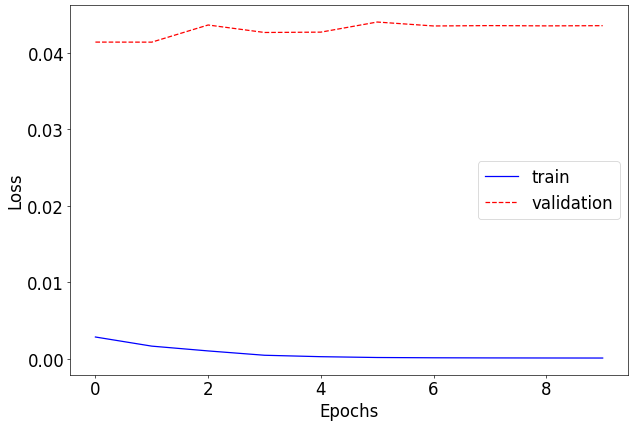

In [19]:
plt.plot([x[0] for x in history], 'b', label = 'train')
plt.plot([x[1] for x in history], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

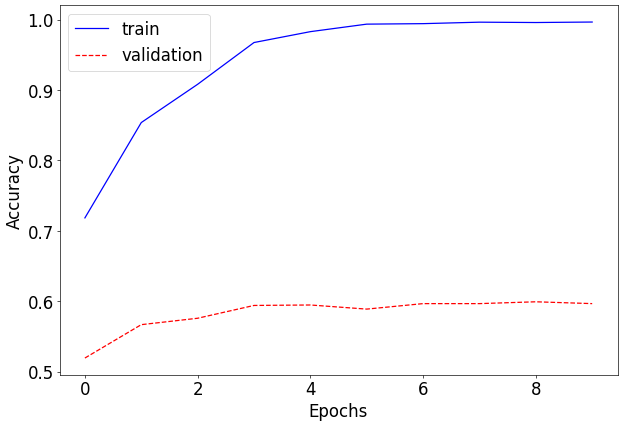

In [20]:
plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [21]:
model = models.resnet50(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8) # transfer learning
model = model.cuda()
model_path = 'best_checkpoint_epoch_9.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss :.8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")

[Test]
[Batch : 1] running test loss : 0.035412244498729706, running test accuracy : 0.59375
[Batch : 20] running test loss : 0.035939431423321365, running test accuracy : 0.645312488079071
[Batch : 40] running test loss : 0.034813610906712714, running test accuracy : 0.660937488079071
test loss : 0.035538102024571694, accuracy : 0.6582446694374084
elapsed time :  2.529754638671875
Test loss : 0.03553810
Test accuracy : 65.82%
